In [15]:
import xgboost as xgb
import shap
import pandas as pd
# 读取C:\MyProject\MIMIC-IPE\加了中介变量的数据集\用于特征选择的数据集.csv
data = pd.read_csv('C:\\MyProject\\MIMIC-IPE\\加了中介变量的数据集\\用于特征选择的数据集.csv')

# data = pd.read_csv('C:\\MyProject\\MIMIC-IPE\\加了中介变量的数据集\\用于COX_sur的特征数据集.csv')
# 设置Subject_id为索引
#data.set_index('Subject_id', inplace=True)
# 从data中保留以下特征['No TD', 'Age', 'Non Solid Tumor', 'Other Solid Tumor', 'Group', 'UFH', 'HF', 'FXaI', 'No CVD MD', 'F.Hosp']以及目标变量['D180D']
features = ['No TD', 'Age', 'Non Solid Tumor', 'Other Solid Tumor', 'Group', 'UFH', 'HF', 'FXaI', 'No CVD MD', 'F.Hosp', 'D180D']
data = data[features]
X = data.drop(columns=['D180D'])
y = data['D180D']

In [ ]:
# 过采样，使用smote算法，以data中'D180D'为目标变量，使之平衡1:1
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=8)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 合并成data_resampled
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)


# 提取特征和标签
X = data.drop(columns=['D180D'])
y = data['D180D']
X_resampled = data_resampled.drop(columns=['D180D'])
y_resampled = data_resampled['D180D']
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# 设置随机种子
np.random.seed(0)
tf.random.set_seed(0)

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled_scaled = scaler.fit_transform(X_resampled)

# 构建自编码器
input_dim = X_scaled.shape[1]
encoding_dim = 2  # 降到2维
input_layer = Input(shape=(input_dim,))

# 编码器
encoder = Dense(128)(input_layer)
encoder = LeakyReLU(alpha=0.01)(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.1)(encoder)
encoder = Dense(64)(encoder)
encoder = LeakyReLU(alpha=0.01)(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.1)(encoder)
encoder_output = Dense(encoding_dim)(encoder)

# 解码器
decoder = Dense(64)(encoder_output)
decoder = LeakyReLU(alpha=0.01)(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.1)(decoder)
decoder = Dense(128)(decoder)
decoder = LeakyReLU(alpha=0.01)(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.1)(decoder)
decoder_output = Dense(input_dim, activation='sigmoid')(decoder)

# 构建自编码器模型
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# 编译和训练自编码器
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=256, shuffle=True, validation_split=0.2)

# 使用训练好的编码器进行降维
encoder_model = Model(inputs=input_layer, outputs=encoder_output)
X_encoded = encoder_model.predict(X_scaled)
X_resampled_encoded = encoder_model.predict(X_resampled_scaled)

# 设置配色和图例标签
colors = {0: '#62B197', 1: '#E1816D'}
labels = {0: 'Non-mortality cases within 180 days', 1: 'Mortality cases within 180 days'}

# 创建散点图
plt.figure(figsize=(14, 7))

# 原始数据的散点图
plt.subplot(1, 2, 1)
for label in y.unique():
    plt.scatter(X_encoded[y == label, 0], X_encoded[y == label, 1], label=labels[label], color=colors[label], alpha=0.5)
plt.title('Original Data')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.grid(True)

# 重采样数据的散点图
plt.subplot(1, 2, 2)
for label in y_resampled.unique():
    plt.scatter(X_resampled_encoded[y_resampled == label, 0], X_resampled_encoded[y_resampled == label, 1],
                label=labels[label], color=colors[label], alpha=0.5)
plt.title('Oversampled data')
plt.xlabel('Encoded Dimension 1')
#plt.ylabel('Encoded Dimension 2')
#plt.legend()
plt.grid(True)

plt.show()

[I 2024-05-22 15:10:05,421] A new study created in memory with name: no-name-16f0a32e-4865-430a-a452-d63c1451d54d
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-05-22 15:10:05,648] Trial 0 finished with value: 0.8090756899350648 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.015247104421284852}. Best is trial 0 with value: 0.8090756899350648.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-05-22 15:10:05,688] Trial 1 finished with value: 0.8408837256493507 and parameters: {'n_estimators': 105, 'max_depth': 2, 'learning_rate': 0.5208128206257097}. Best is trial 1 with value: 0.8408837256493507.
suggest_loguniform has been deprecated in v3.0.0. This feature will be 

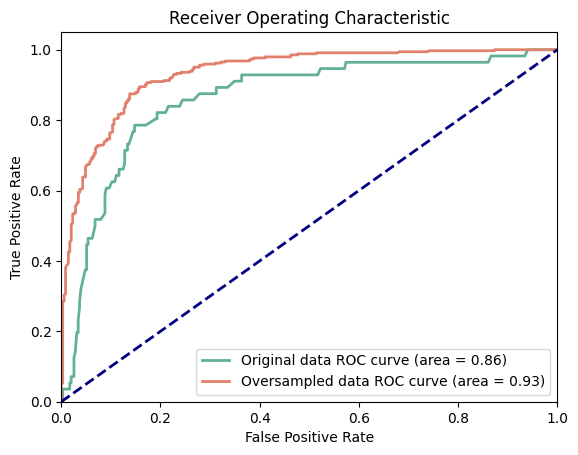

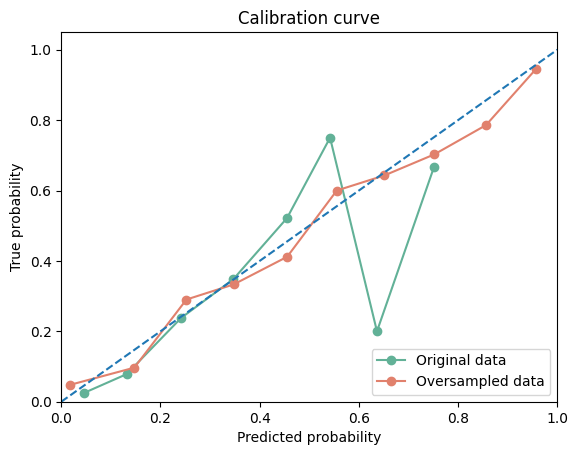

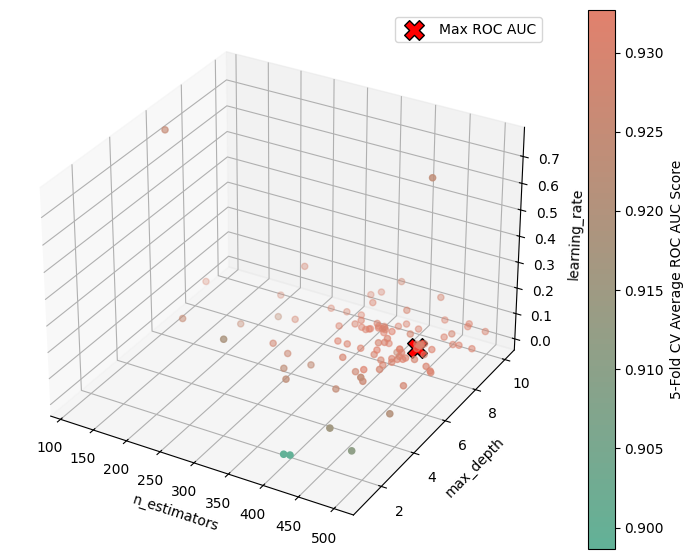

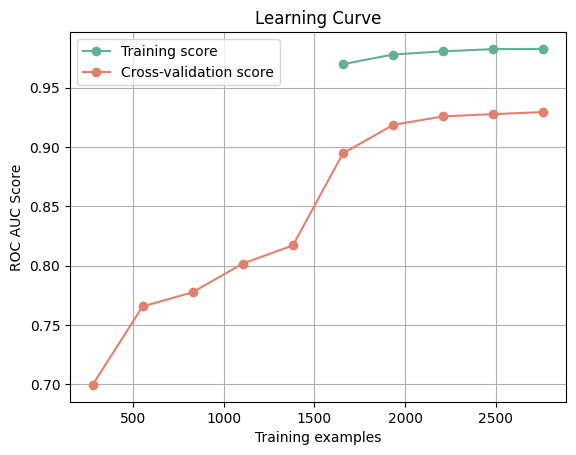

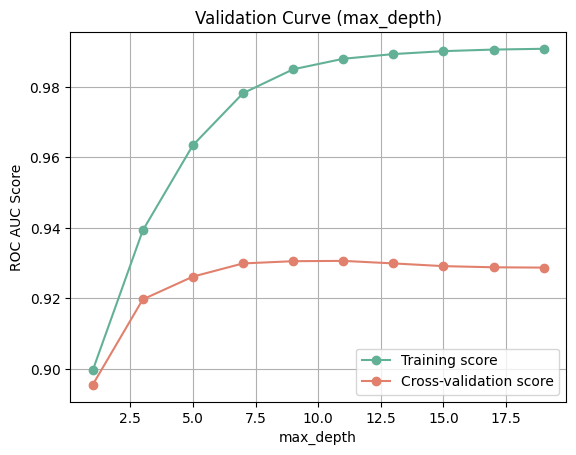

In [11]:
import optuna
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 用于3D散点图
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 训练和评估函数
def train_and_evaluate(X, y, trial_num=100):
    # 分割数据
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 定义优化函数
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        }
        model = XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        return roc_auc_score(y_test, y_pred_proba)

    # 使用optuna优化模型
    trial_results = []  # 重置trial_results
    def logging_callback(study, trial):
        trial_results.append({
            'n_estimators': trial.params['n_estimators'],
            'max_depth': trial.params['max_depth'],
            'learning_rate': trial.params['learning_rate'],
            'roc_auc_score': trial.value
        })

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trial_num, callbacks=[logging_callback])

    # 使用最佳参数训练模型
    model = XGBClassifier(**study.best_params)
    model.fit(X_train, y_train)

    # 计算ROC曲线和AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # 计算校准曲线
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    results_df = pd.DataFrame(trial_results)

    return fpr, tpr, roc_auc, prob_true, prob_pred, model, study, X_train, y_train, results_df

# 创建自定义颜色映射
def create_custom_colormap():
    colors = ['#62B197','#E1816D']
    cmap_name = 'custom_cmap'
    return LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# 修改可视化函数，突出最大ROC AUC分数，并在色带上说明是5折交叉验证平均值
def visualize_3d_scatter_highlight_max(results_df):
    plt.style.use('default')  # 使用默认样式，以确保背景为白色
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 找出最大ROC AUC分数
    max_roc_auc = results_df['roc_auc_score'].max()
    max_roc_point = results_df[results_df['roc_auc_score'] == max_roc_auc].iloc[0]

    # 创建自定义颜色映射
    cmap = create_custom_colormap()

    # 绘制所有点，颜色渐变从#E1816D到#62B197
    scat = ax.scatter(
        results_df['n_estimators'],
        results_df['max_depth'],
        results_df['learning_rate'],
        c=results_df['roc_auc_score'],
        cmap=cmap
    )

    # 在色带上说明这是5折交叉验证的平均ROC AUC值
    cbar = plt.colorbar(scat, label='5-Fold CV Average ROC AUC Score')

    # 特别标记最大ROC AUC分数的点
    ax.scatter(
        max_roc_point['n_estimators'],
        max_roc_point['max_depth'],
        max_roc_point['learning_rate'],
        color='red', s=200, edgecolor='k', label='Max ROC AUC', marker='X'
    )

    ax.set_xlabel('n_estimators')
    ax.set_ylabel('max_depth')
    ax.set_zlabel('learning_rate')
    ax.legend()
    plt.savefig('3d_scatter_plot_highlight_max.png', dpi=300, bbox_inches='tight')
    plt.show()

# 绘制学习曲线
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='#62B197', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='#E1816D', label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('ROC AUC Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# 绘制验证曲线
def plot_validation_curve(model, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(model, X, y, param_name=param_name, param_range=param_range, cv=5, scoring='roc_auc', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', color='#62B197', label='Training score')
    plt.plot(param_range, test_scores_mean, 'o-', color='#E1816D', label='Cross-validation score')
    plt.xlabel(param_name)
    plt.ylabel('ROC AUC Score')
    plt.title(f'Validation Curve ({param_name})')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# 使用原始数据进行训练和评估
fpr_orig, tpr_orig, roc_auc_orig, prob_true_orig, prob_pred_orig, model_orig, study_orig, X_train_orig, y_train_orig, results_df_orig = train_and_evaluate(X, y)

# 使用过采样数据进行训练和评估
fpr_over, tpr_over, roc_auc_over, prob_true_over, prob_pred_over, model_over, study_over, X_train_over, y_train_over, results_df_over = train_and_evaluate(X_resampled, y_resampled)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr_orig, tpr_orig, color='#62B197', lw=2, label='Original data ROC curve (area = %0.2f)' % roc_auc_orig)
plt.plot(fpr_over, tpr_over, color='#E1816D', lw=2, label='Oversampled data ROC curve (area = %0.2f)' % roc_auc_over)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 绘制校准曲线
plt.figure()
plt.plot(prob_pred_orig, prob_true_orig, marker='o', color='#62B197', label='Original data')
plt.plot(prob_pred_over, prob_true_over, marker='o', color='#E1816D', label='Oversampled data')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration curve')
plt.legend(loc="lower right")
plt.show()

# 3D散点图可视化（只针对过采样数据）
visualize_3d_scatter_highlight_max(results_df_over)

# 使用过采样数据的模型绘制学习曲线
plot_learning_curve(model_over, X_resampled, y_resampled)

# 绘制验证曲线（以max_depth为例）
param_range = np.arange(1, 20, 2)
plot_validation_curve(model_over, X_resampled, y_resampled, param_name='max_depth', param_range=param_range)

# 将过采样数据训练得到的最佳模型赋值给model
model = model_over


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
ExactExplainer explainer: 2040it [03:11, 10.15it/s]                          


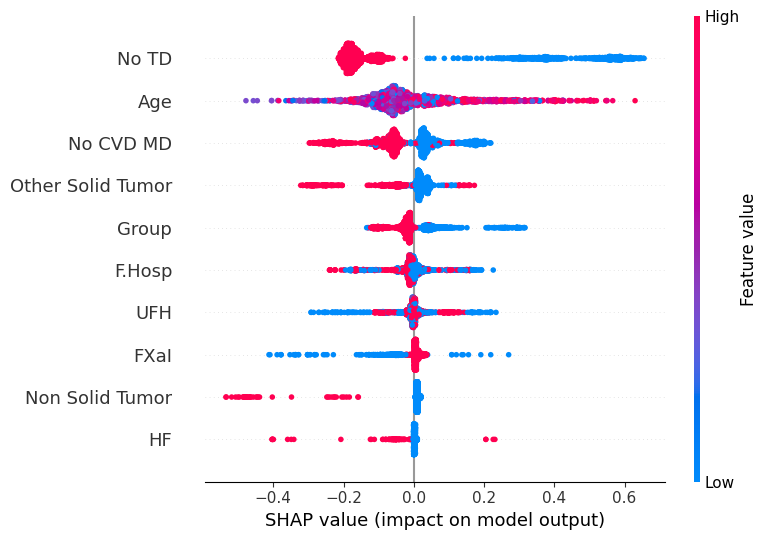

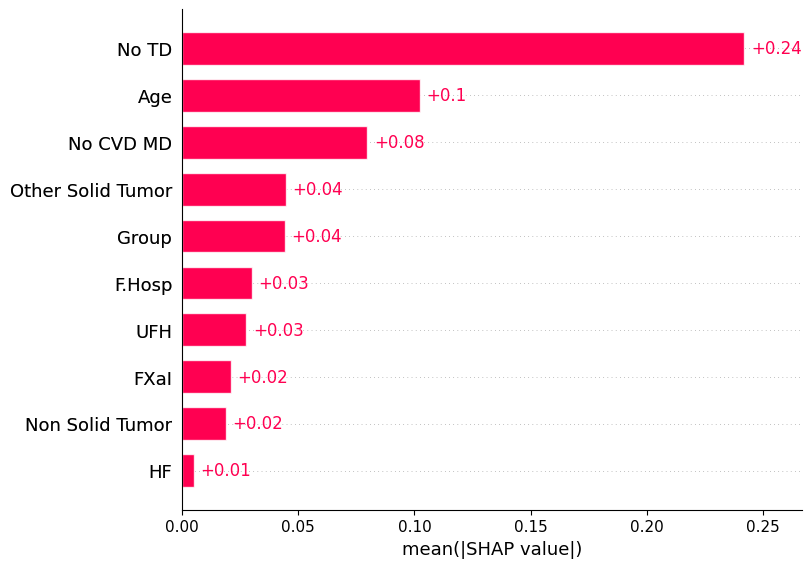

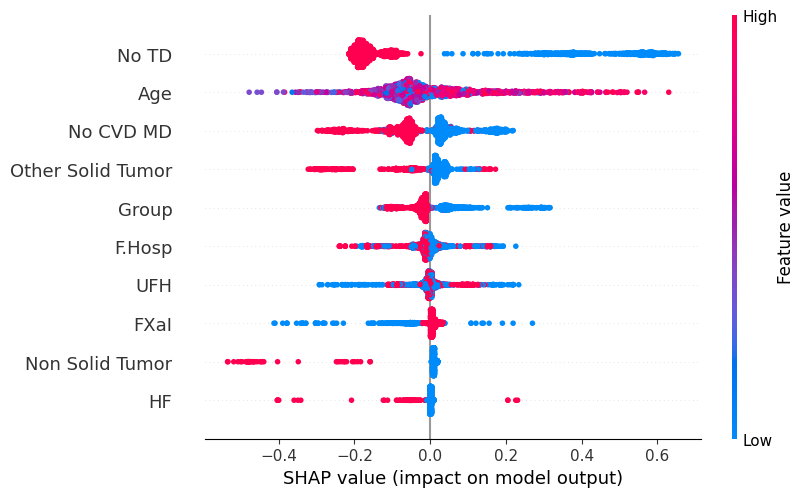

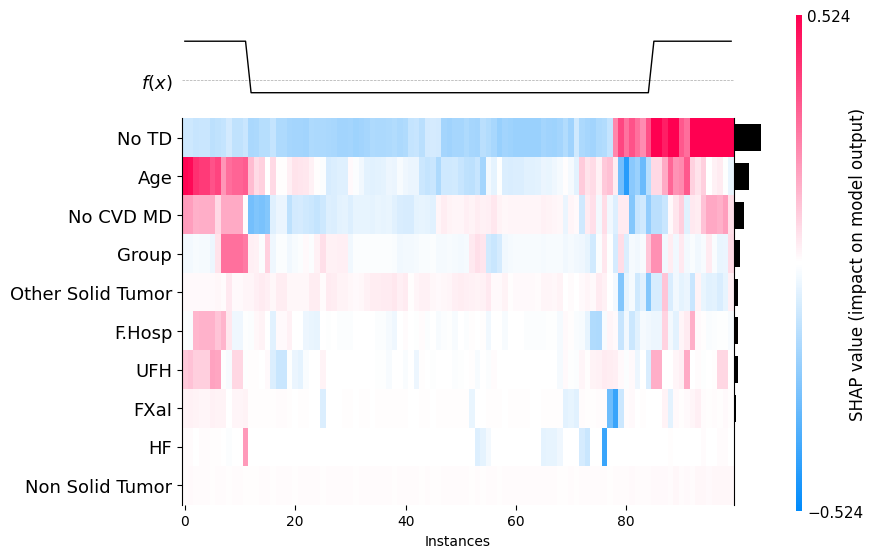

In [12]:
import shap
import matplotlib.pyplot as plt
import math
# 将X中的所有True和False替换为1和0
X = X.replace({True: 1, False: 0})
X_resampled = X_resampled.replace({True: 1, False: 0})

# 初始化SHAP解释器
explainer = shap.Explainer(model.predict, X)

# 计算SHAP值
shap_values = explainer(X)

# 绘制模型整体的SHAP图
shap.summary_plot(shap_values, X)  # 摘要图
shap.plots.bar(shap_values)  # 条形图
shap.plots.beeswarm(shap_values, max_display=20)  # 蜂群图
shap.plots.heatmap(shap_values[:100], max_display=20)  # 热力图     


ExactExplainer explainer: 2040it [03:37,  8.91it/s]                          


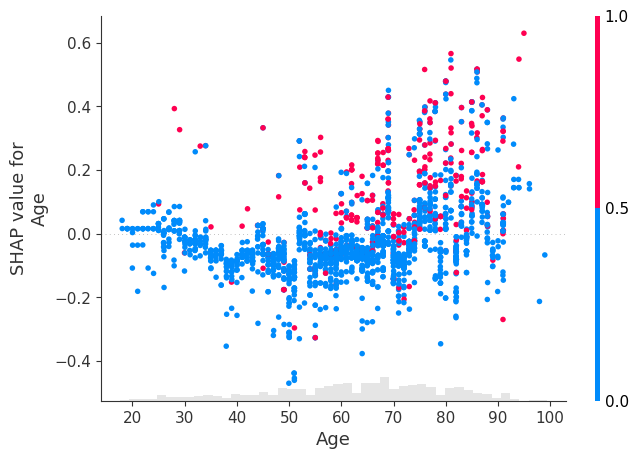

In [6]:

# 选择要绘制依赖图的特征
feature = 'Age'

import numpy as np
import shap

# 确保已经计算了shap_values
shap_values = explainer(X)

# 将现有的y转换成一个array，这里假设y_matched是你的目标变量
y_matched = np.array(y)

# 如果X_matched是一个DataFrame，直接使用列名作为特征名
if isinstance(X, pd.DataFrame) and feature in X.columns:
    # 绘制依赖图，直接使用特征名称和y_matched作为颜色编码
    shap.plots.scatter(shap_values[:, feature], color=y_matched)
else:
    print("特征名称不存在于数据中，请检查特征名称是否正确。")

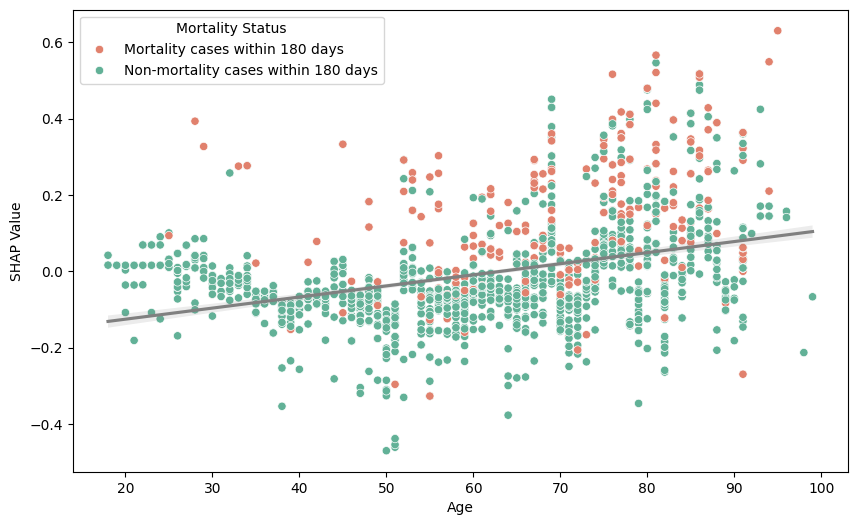

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming shap_values and X have already been calculated

feature_name = 'Age'
labels = {0: 'Non-mortality cases within 180 days', 1: 'Mortality cases within 180 days'}

data_for_plot = pd.DataFrame({
    'SHAP Value': shap_values[:, X.columns.get_loc(feature_name)].values,
    'Feature Value': X[feature_name].values,
    'Mortality Status': [labels[y] for y in y]
})

palette = {'Non-mortality cases within 180 days': '#62B197', 'Mortality cases within 180 days': '#E1816D'}

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_for_plot, x='Feature Value', y='SHAP Value', hue='Mortality Status', palette=palette)
sns.regplot(data=data_for_plot, x='Feature Value', y='SHAP Value', scatter=False, line_kws={"color": "gray"})
plt.xlabel('Age')
plt.ylabel('SHAP Value')
plt.legend(title='Mortality Status', loc='best')

# Save the figure
plt.savefig('SHAP_Values_vs_Age.png', dpi=300, bbox_inches='tight')
plt.show()

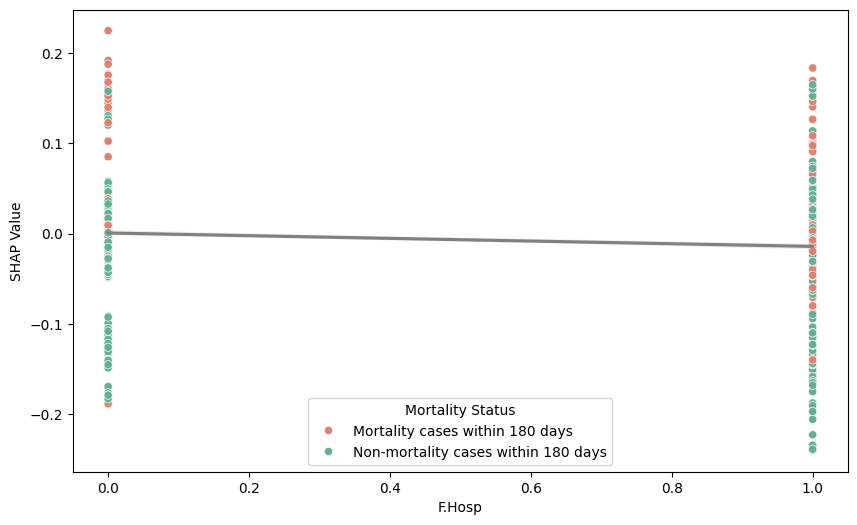

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming shap_values and X have already been calculated

feature_name = 'F.Hosp'
labels = {0: 'Non-mortality cases within 180 days', 1: 'Mortality cases within 180 days'}

data_for_plot = pd.DataFrame({
    'SHAP Value': shap_values[:, X.columns.get_loc(feature_name)].values,
    'Feature Value': X[feature_name].values,
    'Mortality Status': [labels[y] for y in y]
})

palette = {'Non-mortality cases within 180 days': '#62B197', 'Mortality cases within 180 days': '#E1816D'}

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_for_plot, x='Feature Value', y='SHAP Value', hue='Mortality Status', palette=palette)
sns.regplot(data=data_for_plot, x='Feature Value', y='SHAP Value', scatter=False, line_kws={"color": "gray"})
plt.xlabel('F.Hosp')
plt.ylabel('SHAP Value')
plt.legend(title='Mortality Status', loc='best')

# Save the figure
plt.savefig('SHAP_Values_vs_F.Hosp.png', dpi=300, bbox_inches='tight')
plt.show()

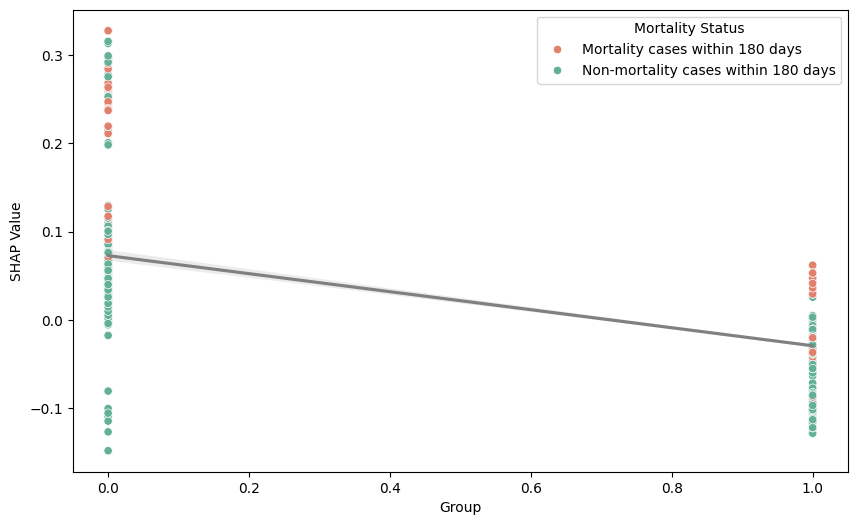

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming shap_values and X have already been calculated

feature_name = 'Group'
labels = {0: 'Non-mortality cases within 180 days', 1: 'Mortality cases within 180 days'}

data_for_plot = pd.DataFrame({
    'SHAP Value': shap_values[:, X.columns.get_loc(feature_name)].values,
    'Feature Value': X[feature_name].values,
    'Mortality Status': [labels[y] for y in y]
})

palette = {'Non-mortality cases within 180 days': '#62B197', 'Mortality cases within 180 days': '#E1816D'}

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_for_plot, x='Feature Value', y='SHAP Value', hue='Mortality Status', palette=palette)
sns.regplot(data=data_for_plot, x='Feature Value', y='SHAP Value', scatter=False, line_kws={"color": "gray"})
plt.xlabel('Group')
plt.ylabel('SHAP Value')
plt.legend(title='Mortality Status', loc='best')

# Save the figure
plt.savefig('SHAP_Values_vs_Group.png', dpi=300, bbox_inches='tight')
plt.show()